# Wireframe Cube 

In [181]:
%matplotlib notebook
import cv2
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from functools import partial
from utils import *

DEBUG = False
CUBE_SIZE = 0.08
IMAGE_FILE_PATH = "../data/images_undistorted/img_0001.jpg"
IMAGE_DISTORTED_FILE_PATH = "../data/images/img_0001.jpg"

POSES_FILE_PATH = "../data/poses.txt"
CALIBRATION_FILE_PATH = "../data/K.txt"
DISTORTION_FILE_PATH = "../data/D.txt"

In [182]:
def get_box_coordinates(origin=np.array([0.0, 0.0, 0.0]), size=1.0):
    coords = np.zeros(shape=(3, 8))
    coords[0, :] = [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]
    coords[1, :] = [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
    coords[2, :] = [0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0]
    coords = coords * size
    coords[0, :] += origin[0]
    coords[1, :] += origin[1]
    coords[2, :] += origin[2]
    return coords

In [183]:
def draw_cube(coords, ax):
    pair = [(0, 1), (1, 2), (2, 3), (3, 0), 
            (4, 5), (5, 6), (6, 7), (7, 4), 
            (0, 4), (1, 5), (2, 6), (3, 7)]

    for v, w in pair:
        ax.plot([coords[0, v], coords[0, w]], 
                [coords[1, v], coords[1, w]], lw=3, c='r')

In [184]:
def project_points(T, x, dist_func=None):
    """ Project 3d points to the camera plane """
    N = x.shape[1]

    x_hom = np.vstack((x, np.ones(shape=(N,))))
    x_hom = T.dot(x_hom)

    x = x_hom[:, :] / x_hom[2, :]

    if dist_func:
        return dist_func(x)
    else:
        return x

In [185]:
def radial_distortion(k1, k2, x):
    xn = deepcopy(x)
    r = np.square(x[0, :]) + np.square(x[1, :])
    d = (1 + k1*r + k2*np.square(r))
    print(f"d[0]={d[0]}")
    for i in range(x.shape[1]):
        xn[:2, i] = xn[:2, i] * d[i]

    return xn

In [186]:
def undistort_image(Id, K, dist_func=partial(radial_distortion, 0, 0)):

    # get x, y (indexes) and z (gray) from image
    h, w = Id.shape[:2]
    u, v = np.meshgrid(np.arange(0, h), np.arange(0, w))
    
    # get undistorted pixeld coordinates
    p_u = np.vstack((u.reshape((1, -1)), 
                     v.reshape((1, -1)), 
                     np.ones(shape=(1, u.size)))).astype(int)
    
    # undistorted normalized pixel coordinates
    p_nu = (np.linalg.inv(K)).dot(p_u) 

    # distorted normalized pixel coordinates
    p_nd = dist_func(p_nu) 

    # distorted pixel coordinates
    p_d = (K.dot(p_nd)).astype(int)                           
 
    Iu = np.zeros(shape=(h, w))
    Iu[p_u[0, :], p_u[1, :]] = Id[p_d[0, :], p_u[1,:]]

    return Iu

In [187]:
def distort_image(img, K, dist_func=partial(radial_distortion, 0, 0)):

    # get x, y (indexes) and z (gray) from image
    h = img.shape[0]
    w = img.shape[1]
    u = np.arange(0, h) 
    v = np.arange(0, w)
    uu, vv = np.meshgrid(u, v)
    
    # get undistorted pixeld coordinates
    p_u = np.vstack((uu.reshape((1, -1)), 
                     vv.reshape((1, -1)), 
                     np.ones(shape=(1, uu.size)))).astype(int)

   	# undistorted normalized pixel coordinates
    print(f"Corner undistorted: {p_u[:, 0]}")
    p_nu = np.linalg.inv(K).dot(p_u) 
    print(f"Corner normalized undistorted: {p_nu[:, 0]}")
    
    # distorted normalized pixel coordinates
    p_nd = dist_func(p_nu) 
    print(f"Corner normalized distorted: {p_nd[:, 0]}")
    
    # distorted pixel coordinates
    print(f"Corner distorted (non approximated): {(K.dot(p_nd))[:, 0]}")
    p_d = (K.dot(p_nd)).astype(int)
    print(f"Corner distorted (approximated): {p_d[:, 0]}")
    
    img_dist = np.zeros(shape=(h, w))
    img_dist[p_d[0, :], p_d[1, :]] = img[p_u[0, :], p_u[1,:]]

    return img_dist

In [188]:
# get checkboard poses from file 
poses = read_poses(POSES_FILE_PATH)

# read intrinsic
K = read_intrinsics(CALIBRATION_FILE_PATH)
print(f"Camera intrinsics:\nK={K}")

# read distortion parameters
D = read_distortion(DISTORTION_FILE_PATH)
print(f"Camera distortion parameters:\nD={D}")

Camera intrinsics:
K=[[420.506712   0.       355.208298]
 [  0.       420.61094  250.336787]
 [  0.         0.         1.      ]]
Camera distortion parameters:
D=[-0.296609, 0.080818]


In [189]:
# generate checkboard corners 
cell_size = 0.04
num_cells = 6
x = np.arange(0, num_cells) * cell_size
y = np.arange(0, num_cells) * cell_size
xv, yv = np.meshgrid(x, y)

# reshape as a matrix N x 3
N = xv.size
points = np.zeros(shape=(3, N))
points[0, :] = xv.reshape(N)
points[1, :] = yv.reshape(N)

In [190]:
# transform checkboard points in camera image
hom_coord = K.dot(project_points(poses[0], points))
pixels = hom_coord[:2, :] / hom_coord[2, :]

# transform cube to image
hom_coord = K.dot(project_points(poses[0], get_box_coordinates(size=CUBE_SIZE)))
pixels_cube = hom_coord[:2, :] / hom_coord[2, :]

<IPython.core.display.Javascript object>


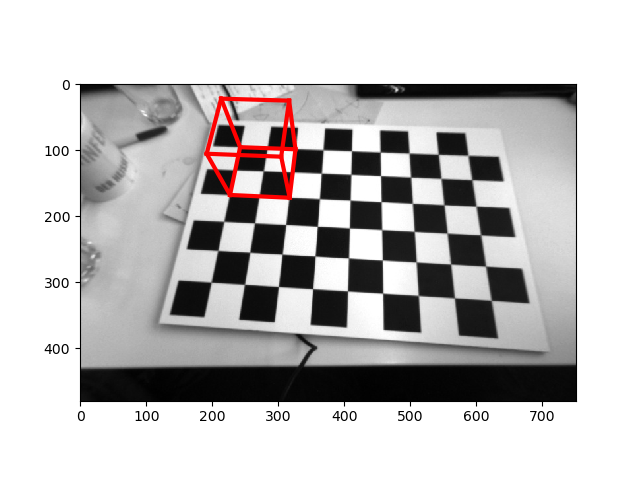

In [191]:
# use flag 0 to read as grayscale image
img_gray = cv2.imread(IMAGE_FILE_PATH, 0)


# plots points and cube on the image
fig, ax = plt.subplots()
ax.imshow(img_gray, cmap='gray')

if DEBUG: 
    ax.scatter(pixels[0, :], pixels[1, :], 30, c='b')

# Plot cube 
draw_cube(pixels_cube, ax)

d[0]=0.9417158653857401


<IPython.core.display.Javascript object>


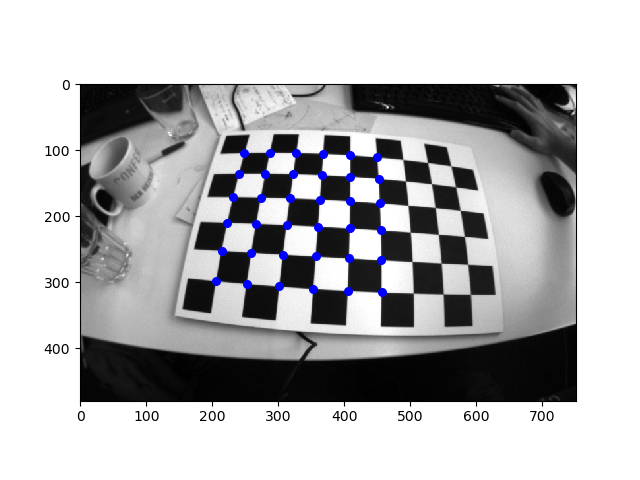

In [192]:
# Plot on distorted image
img_gray_dist = cv2.imread(IMAGE_DISTORTED_FILE_PATH, 0)

# transform checkboard points in camera image using distortion function
hom_coord = K.dot(project_points(poses[0], 
                                 points, 
                                 dist_func=partial(radial_distortion, D[0], D[1])))
pixels = hom_coord[:2, :] / hom_coord[2, :]
fig, ax = plt.subplots()
ax.imshow(img_gray_dist, cmap='gray')
ax.scatter(pixels[0, :], pixels[1, :], 30, c='b')

d[0]=0.7754323562265918


<IPython.core.display.Javascript object>


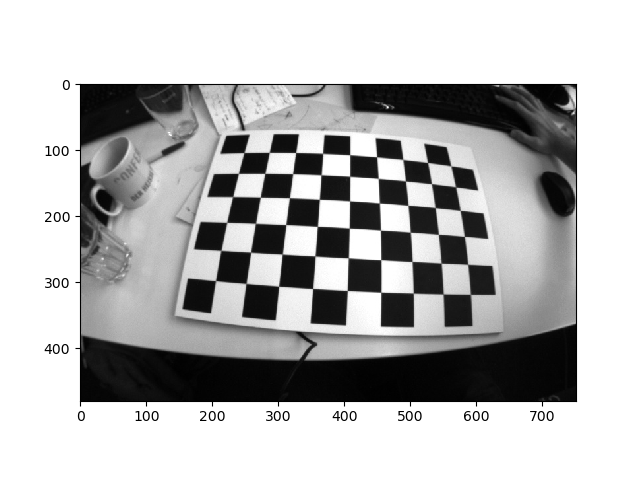

In [193]:
img_gray_udist = undistort_image(img_gray_dist, K, dist_func=partial(radial_distortion, D[0], D[1]))
fig, ax = plt.subplots()
ax.imshow(img_gray_udist, cmap='gray')

# img_gray_dist = distort_image(img_gray, K, dist_func=partial(radial_distortion, D[0], D[1]))
# fig, ax = plt.subplots()
# ax.imshow(img_gray_dist, cmap='gray')
# plt.show()

